In [1]:
from fastquant import get_stock_data
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
training_data = get_stock_data("AAPL", "2003-02-10", "2004-09-10")
testing_data = get_stock_data("AAPL", "2004-09-13", "2005-01-21")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
def data_prep(data):
    df = pd.DataFrame(data=None, columns=['fracChange','fracHigh','fracLow'])
    df['fracChange'] = (data['close']-data['open'])/data['open']
    df['fracHigh'] = (data['high']-data['open'])/data['open']
    df['fracLow'] = (data['open']-data['low'])/data['open']

    return df

In [4]:
x_train = data_prep(training_data)
x_test = data_prep(testing_data)

In [5]:
x_test.head()

,fracChange,fracHigh,fracLow
dt,,,
2004-09-13,-0.008082,0.005296,0.015608
2004-09-14,0.007094,0.008796,0.013054
2004-09-15,-0.004526,0.003392,0.015837
2004-09-16,0.032671,0.044320,0.003408
2004-09-17,0.016141,0.022708,0.004105


In [6]:
x_train.tail()

,fracChange,fracHigh,fracLow
dt,,,
2004-09-02,0.004507,0.008731,0.018874
2004-09-03,0.006283,0.025993,0.000000
2004-09-07,0.010169,0.022316,0.004803
2004-09-08,0.018207,0.024370,0.000560
2004-09-09,-0.011081,0.005539,0.022715


In [7]:
model = hmm.GMMHMM(n_components=4,n_mix=5,algorithm="map",n_iter=100)
model.fit(x_train)

GMMHMM(algorithm='map',
       covars_prior=array([[[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5,...
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]),
       means_weight=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]),
       n_components=4, n_iter=100, n_mix=

In [8]:
model.transmat_

array([[0.39708482, 0.30818584, 0.18946007, 0.10526927],
       [0.36099164, 0.37038837, 0.09851288, 0.1701071 ],
       [0.39748574, 0.44955824, 0.10041038, 0.05254564],
       [0.30128312, 0.36621069, 0.18908055, 0.14342564]])

In [11]:
closes = testing_data['close'].values
opens = testing_data['open'].values
preds = []

observed = x_train.iloc[-10:].values
for i in range(len(x_test)):
    # d = 10
    # create observed data of O_1,...,O_d,O_d+1
    # try 50x10x10 possible values for O_d+1 and find max log lik
    fracChange = np.arange(-0.1,0.1,0.2/50)
    fracHigh = np.arange(0,0.1,0.1/10)
    fracLow = np.arange(0,0.1,0.1/10)
    best = {'next_day': None, 'loglik': -math.inf}
    for change in fracChange:
        for high in fracHigh:
            for low in fracLow:
                next_day = np.array([change,high,low])
                observed_test = np.vstack((observed,next_day))
                log_lik = model.score(observed_test)
                if log_lik > best['loglik']:
                    best['next_day'],best['loglik'] = next_day,log_lik

    best_frac_change = best['next_day']
    observed = np.vstack((observed,next_day))
    # calc predicted close value
    pred_close = best['next_day'][0]*opens[i]+opens[i]
    preds.append(pred_close)

    # drop the O_1 observation to slide the window for the next observation
    observed = observed[1:]

    print(f'predicted close: {pred_close}')
    print(f'actual close   : {closes[i]}')

predicted close: 0.6381511337757111
actual close   : 0.6355360150337219
predicted close: 0.6267688472270966
actual close   : 0.6337500214576721
predicted close: 0.628903300523758
actual close   : 0.6285709738731384
predicted close: 0.626056689977646
actual close   : 0.6491069793701172
predicted close: 0.6500683100223542
actual close   : 0.6632140278816223
predicted close: 0.6559367208480835
actual close   : 0.6733930110931396
predicted close: 0.6714105870723724
actual close   : 0.6787499785423279
predicted close: 0.6776355514526368
actual close   : 0.6592860221862793
predicted close: 0.6587832720279694
actual close   : 0.6655359864234924
predicted close: 0.6660749881267548
actual close   : 0.665893018245697
predicted close: 0.6571816899776459
actual close   : 0.670179009437561
predicted close: 0.6662532649040223
actual close   : 0.679286003112793
predicted close: 0.6746117327213288
actual close   : 0.6907140016555786
predicted close: 0.693643298149109
actual close   : 0.691963970661163

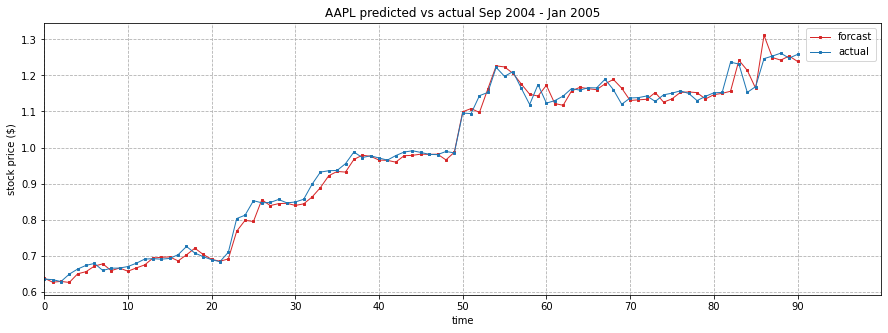

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('AAPL predicted vs actual Sep 2004 - Jan 2005')
time = range(len(preds))
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
ax.plot(time,closes,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,100,10))
ax.set_xlim(0,100)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [57]:
training_data = get_stock_data("AAPL", "2019-01-01", "2021-04-12")
testing_data = get_stock_data("AAPL", "2021-04-05", "2021-04-09")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [58]:
training_data.tail()

,open,high,low,close,volume
dt,,,,,
2021-04-05,123.870003,126.160004,123.070000,125.900002,88651200
2021-04-06,126.500000,127.129997,125.650002,126.209999,80171300
2021-04-07,125.830002,127.919998,125.139999,127.900002,83466700
2021-04-08,128.949997,130.389999,128.520004,130.360001,88844600
2021-04-09,129.800003,133.039993,129.470001,133.000000,106513800


In [59]:
training = data_prep(training_data)
testing = data_prep(testing_data)

In [60]:
training

,fracChange,fracHigh,fracLow
dt,,,
2019-01-02,0.019562,0.025567,0.004261
2019-01-03,-0.012432,0.012085,0.013752
2019-01-04,0.025808,0.027814,0.005051
2019-01-07,-0.005178,0.000874,0.018830
2019-01-08,0.007957,0.015111,0.006954
...,...,...,...
2021-04-05,0.016388,0.018487,0.006458
2021-04-06,-0.002292,0.004980,0.006719
2021-04-07,0.016451,0.016610,0.005484


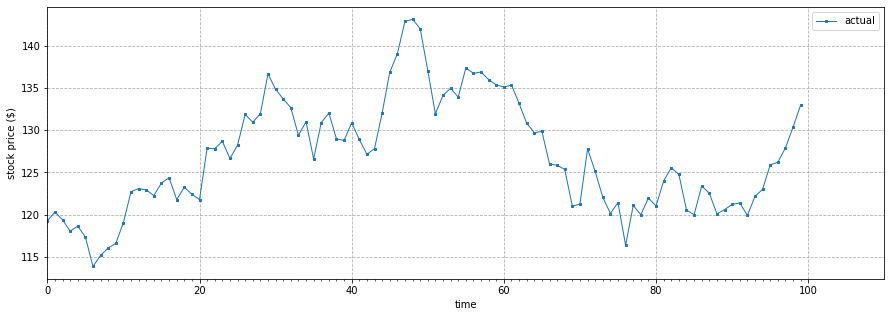

In [61]:
fig, ax = plt.subplots(figsize=(15,5))
time = range(len(training_data[-100:]))
ax.plot(time,training_data['close'][-100:],color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(training_data[-100:])),10)
ax.set_xlim(0,len(training_data[-100:])+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [62]:
model = hmm.GMMHMM(n_components=2,n_mix=4,algorithm="map",n_iter=100)
model.fit(training)

GMMHMM(algorithm='map',
       covars_prior=array([[[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]),
       means_prior=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]),
       means_weight=array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]]),
       n_components=2, n_iter=100, n_mix=4,
       weights_prior=array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]))

In [42]:
closes = testing_data['close'].values
opens = testing_data['open'].values
preds = []

observed = training.iloc[-5:].values
for i in range(len(testing)):
    # d = 10
    # create observed data of O_1,...,O_d,O_d+1
    # try 50x10x10 possible values for O_d+1 and find max log lik
    fracChange = np.arange(-0.1,0.1,0.2/100)
    fracHigh = np.arange(0,0.1,0.1/10)
    fracLow = np.arange(0,0.1,0.1/10)
    best = {'next_day': None, 'loglik': -math.inf}
    for change in fracChange:
        for high in fracHigh:
            for low in fracLow:
                next_day = np.array([change,high,low])
                observed_test = np.vstack((observed,next_day))
                log_lik = model.score(observed_test)
                if log_lik > best['loglik']:
                    best['next_day'],best['loglik'] = next_day,log_lik

    best_frac_change = best['next_day']
    observed = np.vstack((observed,next_day))
    # calc predicted close value
    pred_close = best['next_day'][0]*opens[i]+opens[i]
    preds.append(pred_close)

    # drop the O_1 observation to slide the window for the next observation
    observed = observed[1:]

    print(f'predicted close: {pred_close}')
    print(f'actual close   : {closes[i]}')

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

KeyboardInterrupt: 

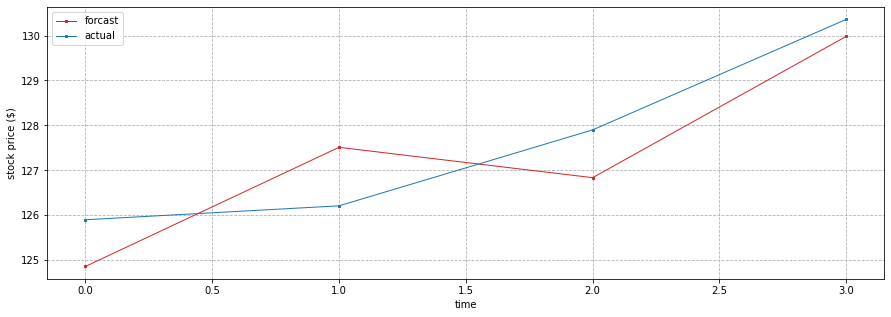

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
time = range(len(preds))
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
ax.plot(time,closes,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [63]:
opening = 133.00
observed = training.iloc[-5:].values

# d = 10
# create observed data of O_1,...,O_d,O_d+1
# try 50x10x10 possible values for O_d+1 and find max log lik
fracChange = np.arange(-0.1,0.1,0.2/100)
fracHigh = np.arange(0,0.1,0.1/10)
fracLow = np.arange(0,0.1,0.1/10)
best = {'next_day': None, 'loglik': -math.inf}
for change in fracChange:
    for high in fracHigh:
        for low in fracLow:
            next_day = np.array([change,high,low])
            observed_test = np.vstack((observed,next_day))
            log_lik = model.score(observed_test)
            if log_lik > best['loglik']:
                best['next_day'],best['loglik'] = next_day,log_lik

# calc predicted close value
pred_close = best['next_day'][0]*opening+opening
preds.append(pred_close)

print(best)

print(f'predicted close: {pred_close}')

{'next_day': array([0.002, 0.01 , 0.01 ]), 'loglik': 69.8057817415528}
predicted close: 133.26600000000002


In [4]:
training_data = get_stock_data("AAPL", "2015-01-01", "2019-08-06")
testing_data = get_stock_data("AAPL", "2019-08-06", "2019-08-20")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
training = data_prep(training_data)
testing = data_prep(testing_data)

In [6]:
model = hmm.GaussianHMM(n_components=2,algorithm="map",n_iter=100)
model.fit(training)

GaussianHMM(algorithm='map', n_components=2, n_iter=100)

In [7]:
closes = testing_data['close'].values
opens = testing_data['open'].values
preds = []

observed = training.iloc[-5:].values
for i in range(len(testing)):
    # d = 5
    # create observed data of O_1,...,O_d,O_d+1
    # try 50x10x10 possible values for O_d+1 and find max log lik
    fracChange = np.arange(-0.1,0.1,0.2/100)
    fracHigh = np.arange(0,0.1,0.1/10)
    fracLow = np.arange(0,0.1,0.1/10)
    best = {'next_day': None, 'loglik': -math.inf}
    for change in fracChange:
        for high in fracHigh:
            for low in fracLow:
                next_day = np.array([change,high,low])
                observed_test = np.vstack((observed,next_day))
                log_lik = model.score(observed_test)
                if log_lik > best['loglik']:
                    best['next_day'],best['loglik'] = next_day,log_lik

    observed = np.vstack((observed,best['next_day']))
    # calc predicted close value
    pred_close = best['next_day'][0]*opens[i]+opens[i]
    preds.append(pred_close)

    # drop the O_1 observation to slide the window for the next observation
    observed = observed[1:]

    print(f'predicted close: {pred_close}')
    print(f'actual close   : {closes[i]}')

predicted close: 49.37196438598633
actual close   : 49.25
predicted close: 49.145615921020514
actual close   : 49.7599983215332
predicted close: 50.35029923248292
actual close   : 50.85749816894531
predicted close: 50.626950767517094
actual close   : 50.247501373291016
predicted close: 50.20442877197266
actual close   : 50.119998931884766
predicted close: 50.55653107452393
actual close   : 52.24250030517578
predicted close: 51.09474092102051
actual close   : 50.6875
predicted close: 51.1701916885376
actual close   : 50.435001373291016
predicted close: 51.37641969299317
actual close   : 51.625
predicted close: 52.97092877197266
actual close   : 52.587501525878906


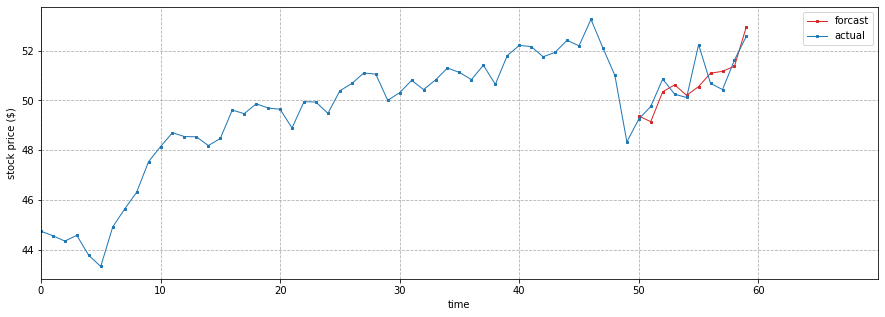

In [59]:
last_50 = training_data['close'].values[-50:]
last = np.append(last_50, closes[0])
fig, ax = plt.subplots(figsize=(15,5))
pred_time = range(len(last_50),len(last_50)+len(preds))
train_time = range(0,len(last_50)+1)
ax.plot(pred_time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
ax.plot(train_time,last,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(pred_time,closes,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1)
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(pred_time)+len(last_50)+10,10))
ax.set_xlim(0,len(pred_time)+len(last_50)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()

In [14]:
training_data.tail()

,open,high,low,close,volume
dt,,,,,
2019-07-30,52.189999,52.540001,51.827499,52.195000,135742800
2019-07-31,54.105000,55.342499,52.825001,53.259998,277125600
2019-08-01,53.474998,54.507500,51.685001,52.107498,216071600
2019-08-02,51.382500,51.607498,50.407501,51.005001,163448400
2019-08-05,49.497501,49.662498,48.145000,48.334999,209572000


In [16]:
testing_data

,open,high,low,close,volume
dt,,,,,
2019-08-06,49.077499,49.517502,48.509998,49.250000,143299200
2019-08-07,48.852501,49.889999,48.455002,49.759998,133457600
2019-08-08,50.049999,50.882500,49.847500,50.857498,108038000
2019-08-09,50.325001,50.689999,49.822498,50.247501,98478800
2019-08-12,49.904999,50.512501,49.787498,50.119999,89927600
2019-08-13,50.255001,53.035000,50.119999,52.242500,188874000
2019-08-14,50.790001,51.610001,50.647499,50.687500,146189600
2019-08-15,50.865002,51.285000,49.917500,50.435001,108909600
2019-08-16,51.070000,51.790001,50.959999,51.625000,110481600


In [25]:
print(training_data['close'].values)

[27.33250046 26.5625     26.56500053 ... 52.10749817 51.00500107
 48.33499908]
